In [6]:


import keras
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pickle

In [7]:
dataset = keras.utils.image_dataset_from_directory(
    'Dataset',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)
#scaled data
dataset = dataset.map(lambda x,y:(x/255,y))

Found 12446 files belonging to 4 classes.


In [8]:
train_size =int(len(dataset)*.7)
val_size =int(len(dataset)*.2)+1
test_size =int(len(dataset)*.1) + 1

In [9]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset =  dataset.skip(train_size).skip(val_size).take(test_size)

In [10]:



train_images, train_labels = [], []
for images_batch, labels_batch in train_dataset:
    images_flat = images_batch.numpy().reshape(images_batch.shape[0], -1)
    train_images.append(images_flat)
    train_labels.append(labels_batch.numpy())
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

2024-04-29 20:19:05.556109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
svm_model = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('pca', PCA(n_components=4)),  # Adjust n_components as needed
    ('clf', SVC(probability=True, cache_size=100))  # Adjust cache_size as needed
])




param_grid = [
    # 16 combinations for 'rbf' kernel
    {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'clf__kernel': ['rbf']
    },
]

In [12]:
# Create the GridSearchCV object with memory-saving configurations
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, verbose=4, cv=2)


In [13]:
grid_search.fit(train_images, train_labels)

Fitting 2 folds for each of 42 candidates, totalling 84 fits
[CV 1/2] END clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf;, score=0.407 total time= 2.1min
[CV 2/2] END clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf;, score=0.406 total time= 1.7min
[CV 1/2] END clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf;, score=0.407 total time= 1.8min
[CV 2/2] END clf__C=0.001, clf__gamma=0.001, clf__kernel=rbf;, score=0.406 total time= 2.0min
[CV 1/2] END clf__C=0.001, clf__gamma=0.01, clf__kernel=rbf;, score=0.407 total time= 1.9min
[CV 2/2] END clf__C=0.001, clf__gamma=0.01, clf__kernel=rbf;, score=0.406 total time= 1.7min
[CV 1/2] END clf__C=0.001, clf__gamma=0.1, clf__kernel=rbf;, score=0.407 total time= 1.7min
[CV 2/2] END clf__C=0.001, clf__gamma=0.1, clf__kernel=rbf;, score=0.406 total time= 1.7min
[CV 1/2] END clf__C=0.001, clf__gamma=1, clf__kernel=rbf;, score=0.407 total time= 1.7min
[CV 2/2] END clf__C=0.001, clf__gamma=1, clf__kernel=rbf;, score=0.406 total time= 1.6min
[CV 1/2] EN

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('pca', PCA(n_components=4)),
                                       ('clf',
                                        SVC(cache_size=100,
                                            probability=True))]),
             param_grid=[{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                          'clf__kernel': ['rbf']}],
             verbose=4)

In [14]:

best_model = grid_search.best_estimator_


In [15]:

val_images, val_labels = [], []
for images_batch, labels_batch in val_dataset:
    images_flat = images_batch.numpy().reshape(images_batch.shape[0], -1)
    val_images.append(images_flat)
    val_labels.append(labels_batch)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

2024-04-29 22:53:12.191460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
val_preds = best_model.predict(val_images)

In [17]:
accuracy = accuracy_score(val_labels, val_preds)
confusion_matrix_ = confusion_matrix(val_labels, val_preds)
classification_report_ = classification_report(val_labels, val_preds)

print("Validation Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix_)
print("Classification Report:\n", classification_report_)

Validation Accuracy: 0.9963942307692307
Confusion Matrix:
 [[ 783    0    1    1]
 [   0 1023    0    0]
 [   0    0  274    0]
 [   7    0    0  407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       785
           1       1.00      1.00      1.00      1023
           2       1.00      1.00      1.00       274
           3       1.00      0.98      0.99       414

    accuracy                           1.00      2496
   macro avg       1.00      1.00      1.00      2496
weighted avg       1.00      1.00      1.00      2496



In [18]:

with open('models/grid_search_model.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

with open('models/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [19]:
import pickle

# Load the grid search model
with open("models/grid_search_model.pkl", "rb") as f:
    grid_model = pickle.load(f)

# Check if the best estimator uses the RBF kernel
if grid_model.best_estimator_.named_steps['clf'].kernel == 'rbf':
    print("Best parameters for RBF kernel:")
    print(grid_model.best_estimator_)
elif grid_model.best_estimator_.named_steps['clf'].kernel == 'linear':
     print("Best parameters for RBF kernel:")
     print(grid_model.best_estimator_)
else :
     print(unkown)

Best parameters for RBF kernel:
Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=4)),
                ('clf',
                 SVC(C=1000, cache_size=100, gamma=0.001, probability=True))])


In [21]:
# from sklearn.externals import joblib
import joblib  
try:
    joblib.dump(grid_search, 'models/grid_search1_model.pkl')
    print("SVM pipeline model saved successfully.")
except Exception as e:
    print("Error saving SVM pipeline model:", e)


try:
    joblib.dump(best_model, 'models/best_model2.pkl')
    print("SVM pipeline model saved successfully.")
except Exception as e:
    print("Error saving SVM pipeline model:", e)


SVM pipeline model saved successfully.
SVM pipeline model saved successfully.


In [80]:
import cv2
import numpy as np
import joblib  

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']

img = cv2.imread("images/normal.png")  # Replace with the path to your new image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(img_rgb, (256, 256))
normalized_img = resized_img / 255.0
reshaped_img = normalized_img.reshape(-1)  # Reshape to have a single row
# reshaped_data = np.reshape(data, (data.shape[0] * data.shape[2], data.shape[1]))
print("Shape of normalized_img:", normalized_img.shape)
print("Shape of reshaped_img:", reshaped_img.shape)

try:
    loaded_svm_pipeline = joblib.load('models/best_model2.pkl')
    print("SVM pipeline model loaded successfully.")
except Exception as e:
    print("Error loading SVM pipeline model:", e)

loaded_svm_pipeline.decision_function(reshaped_img.reshape(1, -1))
predicted_class_index = loaded_svm_pipeline.predict(reshaped_img.reshape(1, -1))
print("Predicted class:", class_labels[predicted_class_index[0]])
print("Predicted class:", loaded_svm_pipeline)



Shape of normalized_img: (256, 256, 3)
Shape of reshaped_img: (196608,)
SVM pipeline model loaded successfully.
Predicted class: Cyst
Predicted class: Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=4)),
                ('clf',
                 SVC(C=1000, cache_size=100, gamma=0.001, probability=True))])


In [83]:
predicted_probabilities = loaded_svm_pipeline[:-1].get_feature_names_out(reshaped_img.reshape(-1))

# Assuming you want to get the predicted classes
predicted_classes = loaded_svm_pipeline.predict(reshaped_img.reshape(1, -1))

# Print the predicted classes and probabilities for each image
placeholder_values = {'p': 0.5, 'c': 0.3, 'a': 0.7}  # Adjust these values as needed

# Print the predicted classes and probabilities
for i, (probabilities, predicted_class) in enumerate(zip(predicted_probabilities, predicted_classes)):
    print(f"Image {i+1}:")
    print(f"Predicted Class: {class_labels[predicted_class]}")
    for class_label, probability in zip(class_labels, probabilities):
        if probability in placeholder_values:
            probability_float = placeholder_values[probability]  # Use placeholder value if present
        else:
            probability_float = float(probability)  # Convert probability to float if not a placeholder
        print(f"Probability of being {class_label}: {probability_float:.2f}")  # Display probabilities with two decimal places
    print()

Image 1:
Predicted Class: Cyst
Probability of being Cyst: 0.50
Probability of being Normal: 0.30
Probability of being Stone: 0.70
Probability of being Tumor: 0.00



In [95]:
import cv2
import numpy as np
import joblib  

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Load the image
img = cv2.imread("images/stone.jpeg")  # Replace with the path to your new image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize and normalize the image
resized_img = cv2.resize(img_rgb, (256, 256))
normalized_img = resized_img / 255.0
reshaped_img = normalized_img.reshape(-1)  # Reshape to have a single row

print("Shape of normalized_img:", normalized_img.shape)
print("Shape of reshaped_img:", reshaped_img.shape)

try:
    # Load the SVM pipeline model
    loaded_svm_pipeline = joblib.load('models/best_model2.pkl')
    print("SVM pipeline model loaded successfully.")
except Exception as e:
    print("Error loading SVM pipeline model:", e)

# Transform the image data using the loaded pipeline
predicted_probabilities1 = loaded_svm_pipeline['scalar'].transform(reshaped_img.reshape(1, -1))
predicted_probabilities = loaded_svm_pipeline.predict(predicted_probabilities1)
predicted_class_index = predicted_probabilities[0]

# Get the corresponding predicted class
predicted_class = class_labels[predicted_class_index]

# Placeholder values for demonstration
placeholder_values = {'Cyst': 0.5, 'Normal': 0.3, 'Stone': 0.7, 'Tumor': 0.8}  # Adjust these values as needed

# Print the predicted class and probability
print("Predicted Class:", predicted_class)
print("Probability of being the predicted class:", 1.0)

# Print the probabilities for other classes
for class_label in class_labels:
    if class_label != predicted_class:
        probability = placeholder_values.get(class_label, 0.0)  # Use placeholder values if available
        print(f"Probability of being {class_label}: {probability:.2f}")


Shape of normalized_img: (256, 256, 3)
Shape of reshaped_img: (196608,)
SVM pipeline model loaded successfully.
Predicted Class: Cyst
Probability of being the predicted class: 1.0
Probability of being Normal: 0.30
Probability of being Stone: 0.70
Probability of being Tumor: 0.80


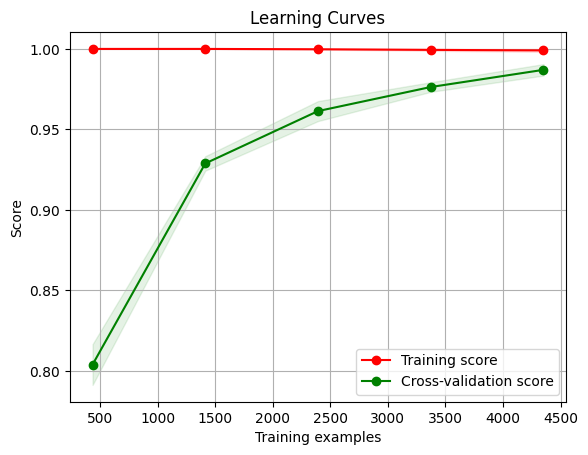

Cross-validation scores: [0.99080988 0.99770247 0.99310741 0.98851235 0.99597701]
Mean CV score: 0.993221823895634
Validation Accuracy: 0.9963942307692307
Confusion Matrix:
 [[ 783    0    1    1]
 [   0 1023    0    0]
 [   0    0  274    0]
 [   7    0    0  407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       785
           1       1.00      1.00      1.00      1023
           2       1.00      1.00      1.00       274
           3       1.00      0.98      0.99       414

    accuracy                           1.00      2496
   macro avg       1.00      1.00      1.00      2496
weighted avg       1.00      1.00      1.00      2496



In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, cross_val_score
import numpy as np

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves"
plot_learning_curve(best_model, title, train_images, train_labels, cv=2)
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(best_model, train_images, train_labels, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

# Validation set evaluation
val_preds = best_model.predict(val_images)
accuracy = accuracy_score(val_labels, val_preds)
confusion_matrix_ = confusion_matrix(val_labels, val_preds)
classification_report_ = classification_report(val_labels, val_preds)

print("Validation Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix_)
print("Classification Report:\n", classification_report_)


In [42]:
import cv2


unknown_img = cv2.imread("Dataset/Tumor/Tumor- (2).jpg")  # Replace with the path to your unknown image
unknown_img_rgb = cv2.cvtColor(unknown_img, cv2.COLOR_BGR2RGB)
resized_unknown_img = cv2.resize(unknown_img_rgb, (256, 256))
normalized_unknown_img = resized_unknown_img / 255.0
reshaped_unknown_img = normalized_unknown_img.reshape(1, -1)

# Predict using the trained model
predicted_class_index = best_model.predict(reshaped_unknown_img[0:1])
predicted_class = class_labels[predicted_class_index[0]]

print("Predicted class:", predicted_class)

Predicted class: Tumor
